In [1]:
import sys
import jax.numpy as jnp
from jax import jit, vmap
import numpy as np
import time
import matplotlib.pyplot as plt
import warnings
import pickle

In [2]:
def empirical_cdf(sample, x):
    return np.mean(sample <= x)

def sample_complexity(epsilon, delta):
    return (1 / (2 * epsilon ** 2)) * np.log(2 / delta)
    
def initializeUniform(gridpoint, a, b):
    return (jnp.exp(1j * gridpoint * b) - jnp.exp(1j * gridpoint * a)) / (1j * gridpoint * (b - a))

def initializeGaussian(gridpoint, mu, sigma):
    return jnp.exp(1j * mu * gridpoint - 0.5 * gridpoint ** 2 * sigma ** 2)

def affineLayer_node(grid, CFxj, gridpoint, Wij):
    return jnp.interp(Wij * gridpoint, grid, CFxj)

def affineLayer(grid, CFx, bi, Wi):
    return  jnp.exp(1j * grid * bi) * jnp.prod(vfunc_AL_node_jit(grid, CFx, grid, Wi), axis=1)

def hilbertTransform(f, grid, x, hilb_grid):
    eval_pt = (x - hilb_grid * h) / h
    return jnp.sum(jnp.interp(hilb_grid * h, grid, f) * jnp.sinc(eval_pt / 2) * jnp.sin(jnp.pi * eval_pt / 2))

def maxLayer(grid, CF, gridpoint, hilb_grid):
    CFz_eval = 0.5 * (1 + jnp.interp(gridpoint, grid, CF)) + 0.5 * 1j * (hilbertTransform(CF, grid, gridpoint, hilb_grid) - hilbertTransform(CF, grid, 0, hilb_grid))
    return CFz_eval

def oneLayerProp(CFx, grid, W, b):

    # Propagate through affine layer
    CFy = vfunc_AL_jit(grid, CFx, b, W)

    # Propagate through max layer
    CFz = vfunc_ML_jit(grid, CFy, grid, hilb_grid)
    
    # return output
    return CFz

def plotEmpiricalCDF(data, axs, num):
    for j in range(0, num):
        cdf(data[j, :], axs, 'r')

def plotECFandCDF(grid, CDFgrid, ECF, CDF, axs, num):
    ECF_real = jnp.real(ECF)
    ECF_imag = jnp.imag(ECF)
    axs[0].plot(grid, ECF_real[0:num, :].T, 'k')
    axs[1].plot(grid, ECF_imag[0:num, :].T, 'k')
    axs[2].plot(CDFgrid, CDF[0:num, :].T, '.k')

def cdf(x, axs, *args, **kwargs):
    x, y = sorted(x), np.arange(len(x)) / len(x)
    return axs.plot(x, y, *args, **kwargs) 

def powerGrid(lb, ub, steps, spacing):
    span = (ub-lb)
    dx = 1.0 / (steps-1)
    return [lb + (i*dx)**spacing*span for i in range(steps)]

def propagateSamplesfull(input_data, out_dim, W, b, num):
    output = np.zeros(shape=(out_dim, num))
    for k in range(0, num):
        input_k = input_data[:, k]
        IL_k = W.dot(input_k) + b
        for j in range(0, out_dim):
            output_kj = max(0, IL_k[j])
            output[j, k] = output_kj
    return output

def propagateSamplesAL(input_data, out_dim, W, b, num):
    output = np.zeros(shape=(out_dim, num))
    for k in range(0, num):
        input_k = input_data[:, k]
        output_k = W.dot(input_k) + b
        output[:, k] = output_k
    return output

def computeCDF(f, grid, x):
    numerator = jnp.exp(-1j * x * (hilb_grid - 0.5) * h) * jnp.interp((hilb_grid - 0.5) * h, grid, f)
    denominator = jnp.pi * (hilb_grid - 0.5)
    return jnp.sum(0.5 * 1j * numerator / denominator) + 0.5

def computePDF(evalpt, grid, CF):
    integrand = (1 / 2 / jnp.pi) * jnp.exp(-1j * evalpt * grid) * CF
    return jnp.trapz(integrand, grid)

def computeECF(gridpoint, data):

    # For each gridpoint tk, we compute the sum (MoG) to get the ECF
    # Input: (scalar, vector)
    # Vectorization #1: gridpoint (L points)
    # Vectorization #2: dataset (# of neurons)

    return (1 / numSamples) * jnp.sum(jnp.exp(1j * gridpoint * data))

def find_last_negative_index(arr):
    non_negative_indices = np.flatnonzero(arr >= 0)
    if len(non_negative_indices) == 0:
        return len(arr) - 1
    if non_negative_indices[0] == 0:
        return 0
    return non_negative_indices[0] - 1

In [3]:
def g_C(x):
    if x>= 0:
        return -x
    return -x

In [4]:
#Set seed
np.random.seed(1)

# Figure formatting
plt.rcParams['font.size'] = 20

# Disable warnings from complex numbers
warnings.filterwarnings("ignore")

# # # vectorize function maps # # #
vfunc_IU      = vmap(initializeUniform, in_axes = (0, None, None))
vfunc_IG      = vmap(initializeGaussian, in_axes = (0, None, None))
vfunc_AL_node = vmap(vmap(affineLayer_node, in_axes = (None, 0, None, 0)), in_axes = (None, None, 0, None))
vfunc_AL      = vmap(affineLayer, in_axes = (None, None, 0, 0))
vfunc_ML      = vmap(vmap(maxLayer, in_axes = (None, None, 0, None)), in_axes = (None, 0, None, None))
vfunc_CDF     = vmap(vmap(computeCDF, in_axes = (None, None, 0)), in_axes = (0, None, None))
vfunc_PDF     = vmap(computePDF, in_axes = (0, None, None))
vfunc_ECF     = vmap(vmap(computeECF, in_axes = (0, None)), in_axes = (None, 1))

# # # jit it up # # #
vfunc_IU_jit      = jit(vfunc_IU)
vfunc_IG_jit      = jit(vfunc_IG)
vfunc_AL_node_jit = jit(vfunc_AL_node)
vfunc_AL_jit      = jit(vfunc_AL)
vfunc_ML_jit      = jit(vfunc_ML)
vfunc_CDF_jit     = jit(vfunc_CDF)
vfunc_PDF_jit     = jit(vfunc_PDF)
vfunc_ECF_jit     = jit(vfunc_ECF)

# define cutoff and resolution
d, L, eps, spacing = 200, 10000, 1E-08, 0.2

# define verification threshold
gamma = 0.05 

# define HT resolution
h, M = 0.5, 5000

# write console output to file
sys.stdout = open('ver1.txt', 'w')

In [5]:
grid = jnp.linspace(-d, d, L)                               # this creates a linear grid

# create grid for H
hilb_grid = jnp.linspace(-M, M, 2 * M + 1)

# generate input data
dmin, dmax = -1., 0.1

epsilon = 0.01
delta = 1 - 0.99
numSamples = int(sample_complexity(epsilon, delta))

input_data1 = np.random.uniform(dmin, dmax, numSamples)
input_data2 = np.random.uniform(dmin, dmax, numSamples)
# mu1, mu2, sigma1, sigma2 = 1, 1, np.sqrt(1), np.sqrt(2)
# input_data1 = np.random.normal(mu1, sigma1, numSamples)
# input_data2 = np.random.normal(mu2, sigma2, numSamples)
input_data = np.stack([input_data1, input_data2])

# compute cutoffs
min_input_data  = jnp.min(input_data)
max_input_data  = jnp.max(input_data)
CDFgrid_input   = jnp.linspace(min_input_data, max_input_data, 100)

# Compute CF and CDF of initial distribution
CFin1 = vfunc_IU_jit(grid, dmin, dmax)
CFin2 = vfunc_IU_jit(grid, dmin, dmax)
# CFin1 = vfunc_IG_jit(grid, mu1, sigma1)
# CFin2 = vfunc_IG_jit(grid, mu2, sigma2)
CFin = jnp.array([CFin1, CFin2])
CDFin = vfunc_CDF_jit(CFin, grid, CDFgrid_input)

# define layer architecture
n_in, n_hidden, n_out = 2, 10, 1

In [6]:
# print out parameters
print('---------------------------')
print('Network parameters: L =', L, ', h =', h, ', M =', M)
print('Verification Threshold: gamma = ', 100 * gamma, '%')


In [7]:
numPass, numFail, numFN, numFP = 0, 0, 0, 0
numTrials = 100
trials = np.arange(1, numTrials + 1)
relGap, verTime = 0, 0

In [8]:
weights0 = []
weights1 = []
bias0 = []
bias1 = []

emploss = []
cfloss = []

outputdata = []
xvalues = []
empcdf = []


for trial in trials:
    
     # generate random weights and biases
    W0 = np.random.uniform(-1., 1., size=(n_hidden, n_in))
    W1 = np.random.uniform(-1., 1., size=(n_out, n_hidden))
    b0 = np.random.uniform(-1., 1., n_hidden)
    b1 = np.random.uniform(-1., 1., n_out)

    weights0.append(W0) 
    weights1.append(W1)
    bias0.append(b0)
    bias1.append(b1)

    # propagate MC samples
    hidden_data = propagateSamplesfull(input_data, n_hidden, W0, b0, numSamples)
    output_data = propagateSamplesAL(hidden_data, n_out, W1, b1, numSamples)
    output_data = output_data.reshape(-1)
    outputdata.append(output_data)
    
    lossActual  = np.sum(output_data >= 0) / numSamples
    emploss.append(lossActual)
    
    
    g_values =  np.vectorize(g_C)(output_data)    
    x_values = np.linspace(min(g_values), max(g_values), 100)
    xvalues.append(x_values)
    empirical_cdf_values = np.array([empirical_cdf(g_values, x) for x in x_values])
    empcdf.append(empirical_cdf_values)
    
    # compute cutoffs
    min_hidden_data = jnp.min(hidden_data)
    min_output_data = jnp.min(output_data)
    max_hidden_data = jnp.max(hidden_data)
    max_output_data = jnp.max(output_data)
    CDFgrid_hidden  = jnp.linspace(min_hidden_data, max_hidden_data, 100)
    CDFgrid_output  = jnp.linspace(min_output_data, max_output_data, 100)

    # run verification
    tic = time.perf_counter()

    # Propagate through first layer
    CFhidden = oneLayerProp(CFin, grid, W0, b0)
    CDFhidden = vfunc_CDF_jit(CFhidden, grid, CDFgrid_hidden)

    # Propagate through affine layer
    CFout = vfunc_AL_jit(grid, CFhidden, b1, W1)
    CDFout = vfunc_CDF_jit(CFout, grid, CDFgrid_output)

    # Compute non-positive area under CDF
    loss = float(abs(CDFout[0, find_last_negative_index(CDFgrid_output)]))
    cfloss.append(loss)
    
    # report time taken
    toc = time.perf_counter()
    
    # Compute probabilitiy-of-success
    POSestimate = (1 - loss) * 100
    POSactual   = lossActual * 100
    relGap      += abs(POSestimate - POSactual)
    verTime     += toc - tic
    relGapAvg   = relGap / trial
    verTimeAvg  = verTime / trial


    print('---------------------------')
    print('Trial #: ', trial)
    print('Verification Time: ', round(toc - tic, 2), 'seconds')
    print('Probability of Success Estimated: ', "%.2f" % round((1 - loss) * 100, 3), '%')
    print('Probability of Success Actual: ', "%.2f" % round(lossActual * 100, 3), '%')
    print('Running average relaxation gap: ', "%.2f" % round(relGapAvg, 3), '%')
    print('Running average verfication time: ', "%.2f" % round(verTimeAvg, 2), 'sec')
    if loss >= gamma and (1 - lossActual) >= gamma:
        print('Neural network failed verification: correct result')
        numFail += 1
    elif loss >= gamma and (1 - lossActual) < gamma:
        print('Neural network failed verification: false negative!')
        numFail += 1
        numFN   += 1
    elif loss < gamma and (1 - lossActual) < gamma:
        print('Neural network passed verification: correct result')
        numPass += 1
    elif loss < gamma and (1 - lossActual) >= gamma:
        print('Neural network passed verification: false positive!')
        numPass += 1
        numFP   += 1
        
print('------------------- SUMMARY -------------------')
print(numPass, 'networks passed, ', numFail, 'networks failed')
print(numFP, 'false positives, ', numFN, 'false negatives')
print('Average Relaxation Gap: ', "%.2f" % round(relGapAvg, 3), '%')
print('Average Verification Time: ', "%.2f" % round(verTimeAvg, 2), 'sec')

arrays_dict = {'weights0':weights0,'weights1':weights1,'bias0':bias0,'bias1':bias1,'emploss':emploss,'cfloss':cfloss,'outputdata':outputdata,'xvalues':xvalues,'empcdf':empcdf}

with open('dkw3.pkl', 'wb') as f:
    pickle.dump(arrays_dict, f)
#sys.stdout.close()

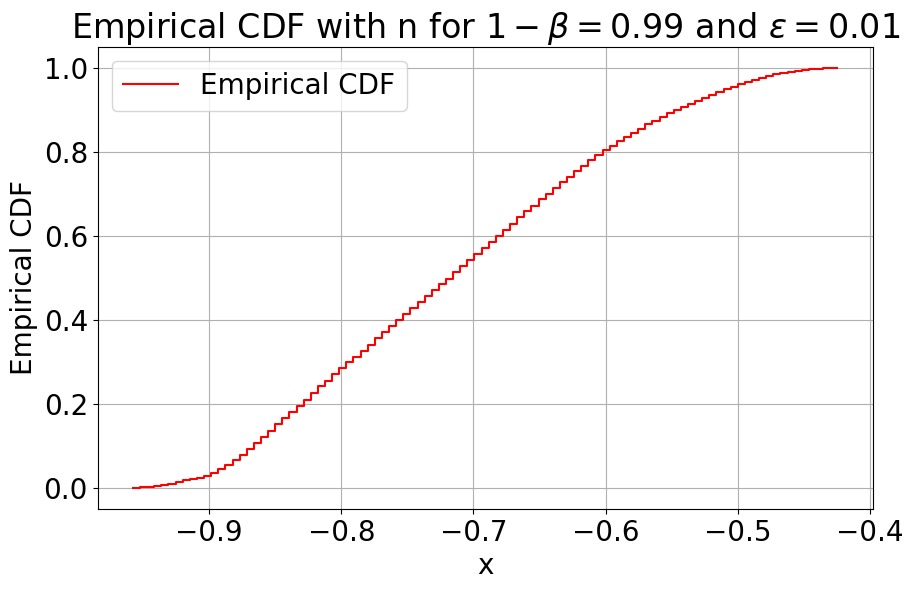

In [13]:
plt.figure(figsize=(10, 6))
plt.step(xvalues[29], empcdf[29], where='post', label='Empirical CDF', color='red')
plt.xlabel('x')
plt.ylabel('Empirical CDF')
plt.grid(True)
plt.legend()
plt.title(r'Empirical CDF with n for $1-\beta = 0.99$ and $\epsilon = 0.01$')
plt.savefig('ex31.jpg')
plt.show()

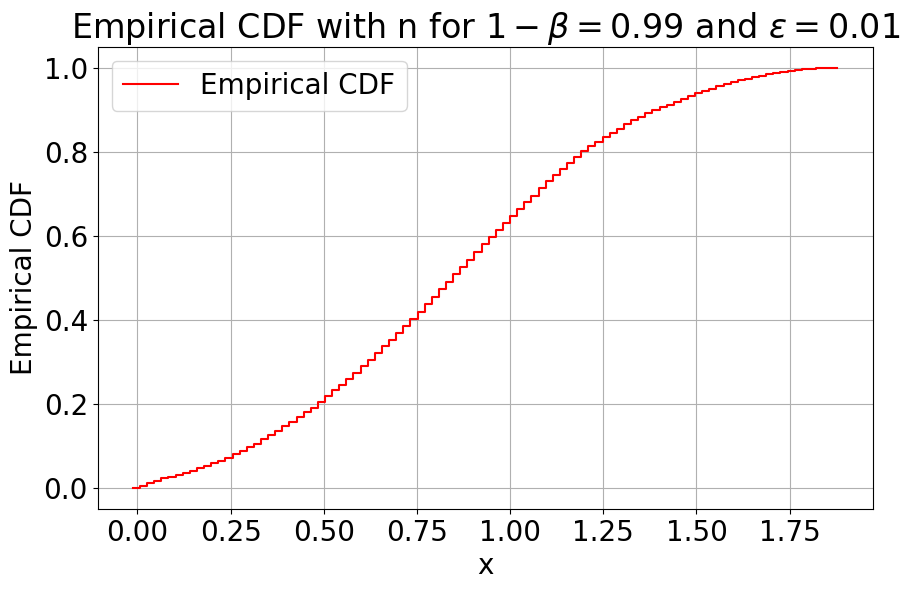

In [14]:
plt.figure(figsize=(10, 6))
plt.step(xvalues[40], empcdf[40], where='post', label='Empirical CDF', color='red')
plt.xlabel('x')
plt.ylabel('Empirical CDF')
plt.grid(True)
plt.legend()
plt.title(r'Empirical CDF with n for $1-\beta = 0.99$ and $\epsilon = 0.01$')
plt.savefig('ex32.jpg')
plt.show()

In [12]:
numSamples

26491